**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1vpNRvLYFs9NddIiuMl3-HIpUBeOj8Up5?usp=sharing)

2. Практический ноутбук 1

3. [Практический ноутбук 2](https://colab.research.google.com/drive/1879mpTpzhYyKwa79sPPG4u4TUBMLjhGg?usp=sharing)


# Классификация писателей

##Импорт библиотек

Начните с подключения необходимых библиотек и модулей. В ходе занятия вы подробнее
разберете их назначение:

In [1]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

Код ниже поможет добавить ваш личный Google Диск в директорию ноутбука, т.е. вы
сможете загрузить сторонние файлы (тексты).

##Загрузка датасета и подготовка данных

`gdown.download()` – непосредственный способ загрузить файлы по ссылке.

В данном случае вы загрузите архив с текстами определенных писателей.

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

'writers.zip'

Команды, именуемые «магическими» предназначены для выполнения кода
непосредственно в консоли или ячейке вашего ноутбука. Они начинаются с символа
восклицательного знака – !.

Далее `!unzip` распаковывает архив в папку с именем указанным после ключа `-d` (в нашем случае папка `writers`)

С помощью команды `!ls` мы выводим содержимое папки (`writers') на экран

Теперь все файлы для работы в вашем распоряжении!

In [3]:
# Распаковка архива в папку writers
!unzip -qo writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

'(Булгаков) Обучающая_5 вместе.txt'
'(Булгаков) Тестовая_2 вместе.txt'
'(Клиффорд_Саймак) Обучающая_5 вместе.txt'
'(Клиффорд_Саймак) Тестовая_2 вместе.txt'
'(Макс Фрай) Обучающая_5 вместе.txt'
'(Макс Фрай) Тестовая_2 вместе.txt'
'(О. Генри) Обучающая_50 вместе.txt'
'(О. Генри) Тестовая_20 вместе.txt'
'(Рэй Брэдберри) Обучающая_22 вместе.txt'
'(Рэй Брэдберри) Тестовая_8 вместе.txt'
'(Стругацкие) Обучающая_5 вместе.txt'
'(Стругацкие) Тестовая_2 вместе.txt'


**Важно!** Если при распаковке файлов вы видите кракозябры вместо названий, необходимо указать кодировку:

`!unzip -qo -O UTF-8 writers.zip -d writers/`

Все три переменных ниже содержат названия строчного типа:
1. Первая – название папки с файлами текстов.
2. Вторая – слово «обучающая» в названии файла (для поиска в дальнейшем).
3. Третья – слово «тестовая» в названии файла (также для поиска).

In [4]:
# Настройка констант для загрузки данных
FILE_DIR  = 'writers'                     # Папка с текстовыми файлами
SIG_TRAIN = 'обучающая'                   # Признак обучающей выборки в имени файла
SIG_TEST  = 'тестовая'                    # Признак тестовой выборки в имени файла

Первые три переменных содержат в себе по пустому списку, что вы видите по пустым
квадратным скобкам – [ ].

● **CLASS_LIST** – в этот список вы поместите имя каждого класса и в итоге получите
единый список с именами всех задействованных писателей;

● **text_train** – в этой переменной в результате будет список, содержащий одну
единственную строку: непрерывный текст для обучения сети;

● **text_test** – аналогично **text_train**, но с назначением текста для
тестирования точности сети.

Первый цикл `for` просто проходится по всем файлам с текстами в общей папке.

Команда `re.match` относится к разряду регулярных выражений, которые вы изучите
отдельно, поскольку на первый взгляд они могут казаться весьма сложными.

Здесь `re.match` ищет совпадения в названиях файлов для деления по классам:

● **class_name** – это имя каждого писателя в названии файла.

● **subset_name** – наименование выборки (обучающая или тестовая).

`re.match` выполнит сортировку всех файлов. При этом данный метод ориентируется на
строку &#39;((.+)) (\S+)_&#39; на первой позиции в своих параметрах. Это условно
кодированные команды для работы с текстом и деления, которое как раз описано выше.
Пока что примите этот параметр как данность, впоследствии вы сможете изучить его при
желании.

Переменная **cls** сохраняет в себе список имен всех писателей в виде индексов, а первая и
единственная в этом блоке команда `print()` информирует о распределении файлов по
выборкам и создании списка с именами писателей.

Команда-менеджер `with` удобна для работы с потоком файлов, в вашем случае – с
текстами писателей. Она гарантированно сократит количество строк для нужной операции
до минимального, а также всегда поможет избежать возможных ошибок кода, которые
могли бы случиться при использовании другого способа.


В блоке ниже `with` открывает каждый текстовый файл в папке и записывает весь текст в
единую строку, сохраненную в переменной **text**. В переменной **subset** закреплена
проверка принадлежности текста либо к обучающей, либо к проверочной выборке, и сразу
после добавляет каждый текст к соответствующей выборке, разделив слова текста только
пробелами.

`len(CLASS_LIST)` – сохраняет в переменной **CLASS_COUNT** общее количество
писателей (их 6).


---
Дополнительная информация ([База знаний УИИ - «**Команда-менеджер with**»](https://colab.research.google.com/drive/1AhKCLV-tHT0woAXZa-WQZifmwrLzoItw))

---

---
Дополнительная информация ([База знаний УИИ - «**Регулярные выражения**»](https://colab.research.google.com/drive/10gyViE3w6pi6GA84roqoULjPllYE-KkK?usp=sharing))

---

In [5]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_train = []
text_test = []

for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса и типа выборки из имени файла
    m = re.match('\((.+)\) (\S+)_', file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        subset_name = m[2].lower()
        # Проверка типа выборки в имени файла
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая либо тестовая - файл обрабатывается
        if is_train or is_test:
            # Добавление нового класса, если его еще нет в списке
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                # Инициализация соответствующих классу строк текста
                text_train.append('')
                text_test.append('')

            # Поиск индекса класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)
            print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.')
            with open(f'{FILE_DIR}/{file_name}', 'r') as f:
                # Загрузка содержимого файла в строку
                text = f.read()
            # Определение выборки, куда будет добавлено содержимое
            subset = text_train if is_train else text_test
            # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += ' ' + text.replace('\n', ' ')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

Добавление класса "О. Генри"
Добавление файла "(О. Генри) Тестовая_20 вместе.txt" в класс "О. Генри", тестовая выборка.
Добавление класса "Стругацкие"
Добавление файла "(Стругацкие) Обучающая_5 вместе.txt" в класс "Стругацкие", обучающая выборка.
Добавление класса "Рэй Брэдберри"
Добавление файла "(Рэй Брэдберри) Обучающая_22 вместе.txt" в класс "Рэй Брэдберри", обучающая выборка.
Добавление класса "Макс Фрай"
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt" в класс "Макс Фрай", тестовая выборка.
Добавление файла "(Рэй Брэдберри) Тестовая_8 вместе.txt" в класс "Рэй Брэдберри", тестовая выборка.
Добавление класса "Булгаков"
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление класса "Клиффорд_Саймак"
Добавление файла "(Клиффорд_Саймак) Обучающая_5 вместе.txt" в класс "Клиффорд_Саймак", обучающая выборка.
Добавление файла "(Клиффорд_Саймак) Тестовая_2 вместе.txt" в класс "Клиффорд_Саймак", тестовая выборка.
Добавление файла "(Булгаков) 

Итого:

● у вас есть 6 имен писателей – названия для каждого класса (первая строка);

● в наличии 6 текстов в обучающей выборке (вторая строка);

● количество символов одного из текстов равно 1 049 518 (третья строка).

In [6]:
# Прочитанные классы текстов
print(CLASS_LIST)

# Количество текстов в обучающей выборке
print(len(text_train))

# Количество символов в одном из текстов обучающей выборки
print(len(text_train[3]))

['О. Генри', 'Стругацкие', 'Рэй Брэдберри', 'Макс Фрай', 'Булгаков', 'Клиффорд_Саймак']
6
3700011


Посмотрите начало каждого текста из обучающей выборки:

In [7]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f'Класс: {CLASS_LIST[cls]}')
    print(f'  train: {text_train[cls][:200]}')
    print(f'  test : {text_test[cls][:200]}')
    print()

Класс: О. Генри
  train:  «Лиса-на-рассвете»   Коралио нежился в полуденном зное, как томная красавица в сурово хранимом гареме. Город лежал у самого моря на полоске наносной земли. Он казался брильянтиком, вкрапленным в ярко
  test :  ﻿Багдадская птица   Без всякого сомнения, дух и гений калифа Гаруна аль-Рашида осенил маркграфа Августа-Михаила фон Паульсена Квигга.  Ресторан Квигга находится на Четвертой авеню — на улице, которую

Класс: Стругацкие
  train:  Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал даже, что такие деревни бывают. Дома круглые, бурые, без окон, торчат на сваях, как сторожевые вышки, а под ним
  test :  ﻿ОТЕЛЬ «У ПОГИБШЕГО АЛЬПИНИСТА»    ГЛАВА 1     Я остановил машину, вылез и снял черные очки. Все было так, как рассказывал Згут. Отель был двухэтажный, желтый с зеленым, над крыльцом красовалась трау

Класс: Рэй Брэдберри
  train:  ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумагу, пиш

Теперь вы узнаете, как превратить текст из последовательного набора слов в
последовательный набор чисел.

###Токенизатор Keras и техника преобразования текста в числовые и векторные представления

Для демонстрации создайте список с набором слов (у вас – числительных), сохраните его
в **sample_text**.

***Tokenizer*** – встроенный класс библиотеки, созданный разработчиками Keras. Он поможет
выделить часть из начального образца текста и составить по нему словарь частоты
повторений слов в образце.

Обратите внимание на несколько важных параметров:

● **num_words** – лимит в 5 слов из общего числа слов в тексте (считайте это за размер
образца);

● **filters** – все символы, которые вы удалите из текста (в sample_text их нет,
но они могут быть в любом другом тексте);

● **oov_token** – здесь вы задаете произвольное имя для каждого слова, что будет
иметь индекс выше вашего лимита, т.е. не входить в образец для словаря (в
примере лимит равен 5).

Дополнительно в комментариях к коду ниже вы можете увидеть описание и других
параметров Tokenizer.

---
Дополнительная информация ([База знаний УИИ - «**Tokenizer**»](https://colab.research.google.com/drive/1ZNlc2nNysNlM5rjYxCbWECOvhHg_u3qI))

---

In [8]:
sample_text = ['один два три четыре пять два Три три четыре четыре четыре пять пять пять пять шесть семь восемь']

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=5, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по текстам
tokenizer.fit_on_texts(sample_text)

Упомянутый ранее менеджер `with` сохранит полученный словарь в файл **f**.

Параметр "wb" – сокращение от двух слов write и binary. Он записывает словарь индексов
и дает компьютеру возможность читать его в виде бинарного кода.

In [9]:
# Сохранение объекта-токенизатора в файл, для чтения используется pickle.dump()
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

---
Дополнительная информация ([База знаний УИИ - «**Модуль pickle**»](https://colab.research.google.com/drive/1T2TgzhjCsOs_2qLuBoIO2hE3OJDPwTBf?usp=sharing))

---

Так как в вашем случае переменная **sample_text** содержит список из одной строки, а не
нескольких, то обращаться к содержимому вы можете только через индекс 0.

Функция `len()` считает количество элементов – слов в тексте, в чем ей также помогает
команда деления строчных элементов `split()`. В образце текста количество слов равно
18.

In [10]:
# Всего слов в тексте
print(len(sample_text[0].split()))

18


Метод `word_index` для словаря частотности выводит все пары по типу:
«Слово: индекс частоты повторений слова».

> Важно: помните, что чем выше такой индекс слова, тем реже оно повторяется в тексте, а не наоборот.

Не смущайтесь от индекса 1 для всех незнакомых слов: как вы помните, данный индекс
получают все слова, которые просто не вошли в заданный лимит словаря.

In [11]:
# Словарь токенизатора с индексами слов
tokenizer.word_index

{'неизвестное_слово': 1,
 'пять': 2,
 'четыре': 3,
 'три': 4,
 'два': 5,
 'один': 6,
 'шесть': 7,
 'семь': 8,
 'восемь': 9}

Добавление команды `items()` к предыдущему коду объединит уже выведенные пары в
кортежи – такие пары, которые вы уже не можете изменить. Они сохраняются вместе до
конца выполнения кода.

In [12]:
# Представление словаря в виде списка пар (слово, индекс)
list(tokenizer.word_index.items())

[('неизвестное_слово', 1),
 ('пять', 2),
 ('четыре', 3),
 ('три', 4),
 ('два', 5),
 ('один', 6),
 ('шесть', 7),
 ('семь', 8),
 ('восемь', 9)]

И вот ваш первый шаг на пути к обучению сети после составления словаря частотности:
преобразуйте исходный словарь с текстом в последовательность индексов слов. В этом
поможет функция `texts_to_sequences()`:

In [13]:
# Представление исходного текста в виде последовательности индексов слов
sample_seq = tokenizer.texts_to_sequences(sample_text)
print(sample_seq)
print(len(sample_seq[0]))

[[1, 1, 4, 3, 2, 1, 4, 4, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1]]
18


Достигнув этого блока кода, вы уже познакомились с существенной частью занятия!
Дальше представлен полезный способ выполнения цикла `for` в одну строку. При этом
такой цикл можно выполнить сразу внутри определенной структуры данных и получить
ее как результат. Здесь используется список: вы размещаете однострочный цикл `for`
внутри квадратных скобок.

Рассмотрите подробнее, что представлено в данном коде:
1. Создана переменная **x_train**, и в нее записан список.
2. Внутри списка размещен цикл `for` в одну строку.
3. Цикл организован следующим образом:

    * все до команды `for` – та операция, которую необходимо выполнить с
каждым элементом списка **sample_seq** (здесь – выделить каждые три
элемента последовательно);

    * далее сама команда `for` для каждого элемента i;

    * потом диапазон выполнения `range()` – от первого элемента в
**sample_seq** до последнего (`len(sample_seq[0])`) и число 3 – шаг
перемещения по диапазону.

Что вам это даст? Как вы узнали в начале занятия, нейронная сеть должна обучаться на
ряде примеров, а не на одном. Таким циклом вы и делите список индексов **sample_seq**
на несколько подвыборок. Если всего в **sample_seq** 18 слов (индексов слов), то при
шаге равном 3 вы получите количество выборок для обучения равное 18:3, т.е. 6 штук.

Выведите новый список **x_train** и посмотрите, действительно ли он содержит 6
подвыборок:

In [14]:
# Выборка получается разбивкой последовательности индексов на отрезки (подпоследовательности) по несколько индексов каждый
# В общем случае отрезки могут частично накладываться друг на друга или отстоять на некотором расстоянии

x_train = [sample_seq[0][i:i + 3] for i in range(0, len(sample_seq[0]), 3)]

x_train

[[1, 1, 4], [3, 2, 1], [4, 4, 3], [3, 3, 2], [2, 2, 2], [1, 1, 1]]

Все верно!

Кстати, вы часто будете пользоваться таким способом размещения цикла в списке в одну
строку. Это очень удобно, и упрощает чтение кода, если только во всем разобраться.

Вот вы и дошли до метода преобразования списка из индексов слов в матрицу Bag Of
Words – способа обработки текста, который вы разбирали в начале занятия.
Преобразование списка индексов в Bag Of Words происходит за счет метода
`sequences_to_matrix()`.

Если "texts_to_sequences" буквально переводится как «тексты в
последовательности», то "sequences_to_matrix" – как «последовательности в
матрицу».

Вы получили первую тренировочную выборку в формате Bag Of Words!

In [15]:
# Представление списка подпоследовательностей в виде разреженной матрицы:
# каждая подпоследовательность представляется как вектор bag of words
tokenizer.sequences_to_matrix(x_train)

array([[0., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

###Преобразование текстовых данных в числовые и векторные представления для обучения нейросети

Теперь вы готовы применить полученные знания в обучении реальной модели НС!

Ранее вы создали маленький образец текста **sample_text**. Там вы ограничили размер
словаря до индекса частотности равного 5, ведь и сам текст был всего из 18 слов. Теперь
же вы переходите к работе с теми текстами писателей, что ранее загрузили, а потому
понадобится более объемный словарь.

Это будет переменная **VOCAB_SIZE**, равная 20 000 индексам слов.

Так вы выбрали общий размер словаря, а посредством `WIN_SIZE = 1000` вы задаете
размер каждой подвыборки внутри общей базы. Так сколько же тогда вы получите
подвыборок?

20 000 : 1000 = 20

20 примеров для обучения!

`WIN_HOP = 100` – шаг или же попросту количество слов, на которое будет смещаться
словарь от начала общего списка до самого конца, чтобы получить отличающиеся
подвыборки.

In [16]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 1000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 100                          # Шаг окна разбиения текста на векторы

**Токенизация и преобразование в последовательности**

В следующем блоке кода вы впервые увидите, как работает класс в Python:

***Class*** – это объект языка программирования, содержащий и данные, и функции для
работы с ними. Вы всегда можете создать свой класс, который будет выполнять
множество полезных операций, если их правильно задать.

Этим `class` и удобнее функции `def`. Его функционал можно сделать практически
неограниченным. Тогда как при использовании функции `def` придется писать куда
большие блоки кода, и не факт, что результат будет тот же.

О том, как правильно создать свой класс, вы узнаете в отдельном занятии. В блоке ниже
создан класс `timex`, в основе которого лежит модуль для работы с реальным временем
`time`.

`timex` используют для измерения времени выполнения дальнейших операций.

> Важно: `time.time()` засекает текущее время, а `{:.2f}` в
форматированной строке выводит время в виде десятичной дроби с
двумя знаками (2f) после запятой.

In [17]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

Код ниже вы уже видели на примере.

Далее выполняется та же операция по формированию словаря частотности, только его
объем уже равен значению **VOCAB_SIZE**, а это 20 000.

Менеджер `with` поможет гладко обработать весь блок кода со словарем с помощью
`timex()`. Так вы узнаете время обработки всего диапазона слов токенайзером.
Учитывайте, что токенайзер еще не преобразует всю выборку сразу в одни лишь индексы
(числовые значения), а формирует пары «слово: индекс».

In [19]:
# Токенизация и построение частотного словаря по обучающим текстам
with timex():
    # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
    tokenizer.fit_on_texts(text_train)

    # Построение словаря в виде пар слово - индекс
    items = list(tokenizer.word_index.items())

Время обработки: 2.36 с


В дальнейших строках комментарии к коду вполне делают свое дело, не забудьте
прочитать аннотации!

In [20]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('бы', 27), ('сказал', 28), ('вы', 29), ('было', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('вот', 39), ('когда', 40), ('если', 41), ('уже', 42), ('был', 43), ('нет', 44), ('ни', 45), ('их', 46), ('ну', 47), ('чтобы', 48), ('до', 49), ('для', 50), ('ему', 51), ('ничего', 52), ('может', 53), ('или', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('чем', 63), ('него', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('ли', 72), ('время', 73), ('тебе', 74), ('вас', 75), ('со', 76), ('нибудь

In [21]:
# Проверка индекса слова в словаре
try:
    print('Интересующее слово имеет индекс:', tokenizer.word_index[input('Введите слово: ')])
except:
    print('Интересующего вас слова нет в словаре')

Введите слово: интерес
Интересующее слово имеет индекс: 3825


---
Дополнительная информация ([База знаний УИИ - **«Операторы try...except для обработки исключений»**)](https://colab.research.google.com/drive/1m31BBr03P6o5F-50VBxFsdjbv-IrS51L?usp=sharing))

---

А далее вы как раз преобразуете текст в чистую последовательность индексов по частоте
повторений слов. Вы это рассматривали немного раньше в занятии.

In [24]:
# Преобразование обучающих и проверочных текстов в последовательность индексов согласно частотному словарю
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_train[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал даже, что та
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472]
Время обработки: 2.49 с


Рассмотрите функцию вывода статистики по всем загруженным текстам –
`print_text_stats()`, которая:
1. Задает название выборки (параметр **title** – «обучающая» или «тестовая»).
2. Отдельно проходит по каждому тексту (параметр **texts**).
3. Проходит по сформированным последовательностям индексов слов (параметр **sequences**).
4. Выводит количество символов каждого текста (счетчик переменной **chars**).
5. Выводит количество слов каждого текста (счетчик переменной **words**).
6. Суммирует все символы и слова в каждой выборке целиком (последняя строка в
коде функции).

Обратите внимание на вывод функции.

In [25]:
# Функция вывода статистики по текстам
def print_text_stats(title, texts, sequences, class_labels=CLASS_LIST):
    # Суммарное количество символов и слов в тексте
    chars = 0
    words = 0

    print(f'Статистика по {title} текстам:')

    # Вывод итогов по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])
        words += len(sequences[cls])

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words))

# Вывод итогов по текстам
print_text_stats('обучающим', text_train, seq_train)
print_text_stats('тестовым', text_test, seq_test)

Статистика по обучающим текстам:
О. Генри          1049518 символов,  160607 слов
Стругацкие        2042470 символов,  313012 слов
Рэй Брэдберри     1386455 символов,  214454 слов
Макс Фрай         3700011 символов,  568533 слов
Булгаков          1765649 символов,  261465 слов
Клиффорд_Саймак   1609508 символов,  251502 слов
----
В сумме          11553611 символов, 1769573 слов

Статистика по тестовым текстам:
О. Генри           349663 символов,   53238 слов
Стругацкие         704847 символов,  108621 слов
Рэй Брэдберри      868674 символов,  132524 слов
Макс Фрай         1278192 символов,  196731 слов
Булгаков           875043 символов,  132730 слов
Клиффорд_Саймак    318812 символов,   50360 слов
----
В сумме           4395231 символов,  674204 слов



**Создание обучающей и проверочной выборок**

В этом разделе вам предстоит большая работа, но вы уже на финишной прямой!

Функция `split_sequence` поможет поделить одну общую последовательность
(параметр sequence) из индексов слов на то количество примеров, которые вы захотите
(параметр **win_size**) со сдвигом по всей выборке, равному размеру шага (параметр
**hop**). Вы делали то же с помощью вложенного в список цикла `for`, только теперь он
задан как результат работы функции. Кто знает, сколько раз вам придется к этому
прибегать, поэтому лучше сделать функцию!

Есть и вторая функция – `vectorize_sequence()`, которая полезна двумя операциями:

* деление общей последовательности на части с помощью функции
`split_sequence()`;

* формирование бинарных (содержащих только 0 и 1) последовательностей верных
ответов в соответствии с каждым примером для тренировочной и для тестовой
выборок (метод `to_categorical()`).

Тогда в результате использования `vectorize_sequence()` вы всегда получите два
готовых numpy-массива. Если подадите в функцию данные для обучения, то это будет
обучающая выборка и выборка ответов для нее. То же будет и в случае с формированием
массивов на основе тестовых данных.

In [26]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

Сформируйте выборки, посмотрите на их размер и заодно измерьте время выполнения
операции. Последнее может отличаться в зависимости от среды выполнения и мощностей
ПК:

In [27]:
# Формирование обучающей и тестовой выборок
with timex():
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(17640, 1000) (17640, 6)
(6686, 1000) (6686, 6)
Время обработки: 1.76 с


Один из примеров последовательности индексов для обучения сети выглядит так:

In [28]:
# Вывод отрезка индексов тренировочной выборки
print(x_train[0])

[ 4725     7  2449  1757     1     3     1     1    11     1  7581     3
  3274     1     1   272  1057    16   259  2150     7     1     1   644
     9  2552     1     1     3  1652  7931  9662   952    11    27    55
     1   133   130     1   122  1409  3211     1   907     1  1158 15510
     1    36   193     1    63     1  2609  4726     1   953     1  1891
     1  2927     3     1 10220     2     1 17013     1   221     1     1
    11 15511     1   145   721     1     1     1   593   272     1     2
     1  1934     1  6737    17     1     1   371 14307    78    15  1460
     1  7932 10855  1200     7     1     1     1     1  7932     1  8682
  7582    50    64     1 14308  2656   246   272  4242    80  2414 11508
     4   743  3362     3  1757  4243  4727     8  8288     1     1  1310
  6255  2121     1   917   281     1  7010   336  7011   221 12294    17
     1   144 11508   886     8  6738  9134  5561  4861    31  4591     1
     2     1  1217     1 13217  3824     7  7267   

Сформируйте отдельные обучающую и тестовую выборки в формате Bag Of Words, чтобы
в дальнейшем использовать оба способа обработки текстов при обучении НС. И узнайте
время выполнения этих двух операций:

In [29]:
# Формирование выборок текстов в виде разреженных матриц (bag of words)
with timex():
    # На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование типа
    x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
    x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

    # Вывод формы обучающей выборки в виде разреженной матрицы Bag of Words
    print(x_train_01.shape)
    # Вывод фрагмента отрезка обучающего текста в виде Bag of Words
    print(x_train_01[0][0:100])

(17640, 20000)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1.]
Время обработки: 9.90 с


##Различные архитектуры нейронных сетей для классификации текста

###Сервисные функции


Пусть код ниже не вводит вас в ступор, там просто добавлена пара созданных функций
для удобства компиляции и обучения модели. Именно это и будет делать функция под
именем `compile_train_model()`. В ее параметры вы передадите все, что
необходимо для компиляции и обучения:

● саму модель НС;

● выборки;

● функцию оптимизации;

● количество эпох обучения;

● размер шага по выборке;

● размер полотна графика.

Да, функция даже нарисует для вас графики точности и ошибки сети! Не зря вы
познакомились с библиотекой matplotlib (блок кода по отрисовке графиков последний в
данной функции).

Также в ячейке ниже написана функция `eval_model()`. Она оценивает точность работы
сети при распознавании текстов, дает статистику по верно и неверно распознанным
классам, и рисует график-матрицу ошибки предсказания сети! Это очень красивый
график, похожий на яркую шахматную доску. Как его правильно читать, вы узнаете чуть
позже.

Последняя функция `compile_train_eval_model()` объединяет в себе функционал
двух предыдущих. Ей вы и будете пользоваться, чтобы в будущем строить разные
архитектуры, при этом в одну строку задавая компиляцию модели, обучение и оценку
точности!

In [30]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

---
Дополнительная информация ([База знаний УИИ | **Матрица ошибок confusion_matrix()**](https://colab.research.google.com/drive/1xInJ97OzDUg92kEsScjqnLs7xB3h20jn#scrollTo=3OQbyFXlldGI))

---

### BagOfWords


Попробуйте способ обучения сети на Bag Of Words. Сеть будет угадывать одного из
шести авторов для каждого примера текста. На выходном слое нужно указать
функцию активации `softmax`.

Соберите полносвязную модель, подобную той, что вы уже рассматривали на первом
занятии по НС. А на обучение и тест сети подайте выборки формата Bag Of Words
(**x_train_01** и **x_test_01**), которые вы подготовили ранее.

Функция `compile_train_eval_model()` также выведет статистику по
сформированной модели до начала обучения. Смотрите:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │     4,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,002,206 (15.27 MB)

 Trainable params: 4,001,806 (15.27 MB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9351 - loss: 0.1931 - val_accuracy: 0.8789 - val_loss: 0.4195
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 3.5326e-04 - val_accuracy: 0.8872 - val_loss: 0.3651
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 1.5614e-04 - val_accuracy: 0.8850 - val_loss: 0.3604
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 1.0546e-04 - val_accuracy: 0.8862 - val_loss: 0.3543
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 7.5892e-05 - val_accuracy: 0.8883 - val_loss: 0.3501
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 6.0336e-05 - val_accuracy: 0.8887 - val_loss: 0.3468
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 4.9651e-05 - val_accuracy: 0.8908 - val_loss: 0.3412
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 -

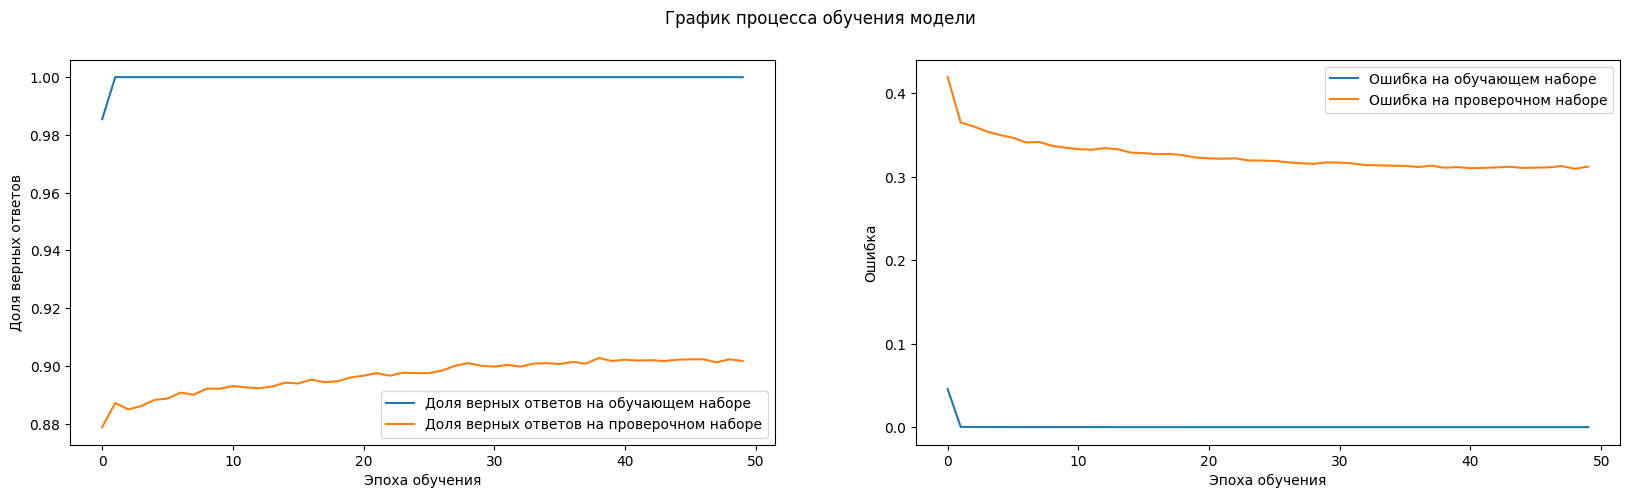

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


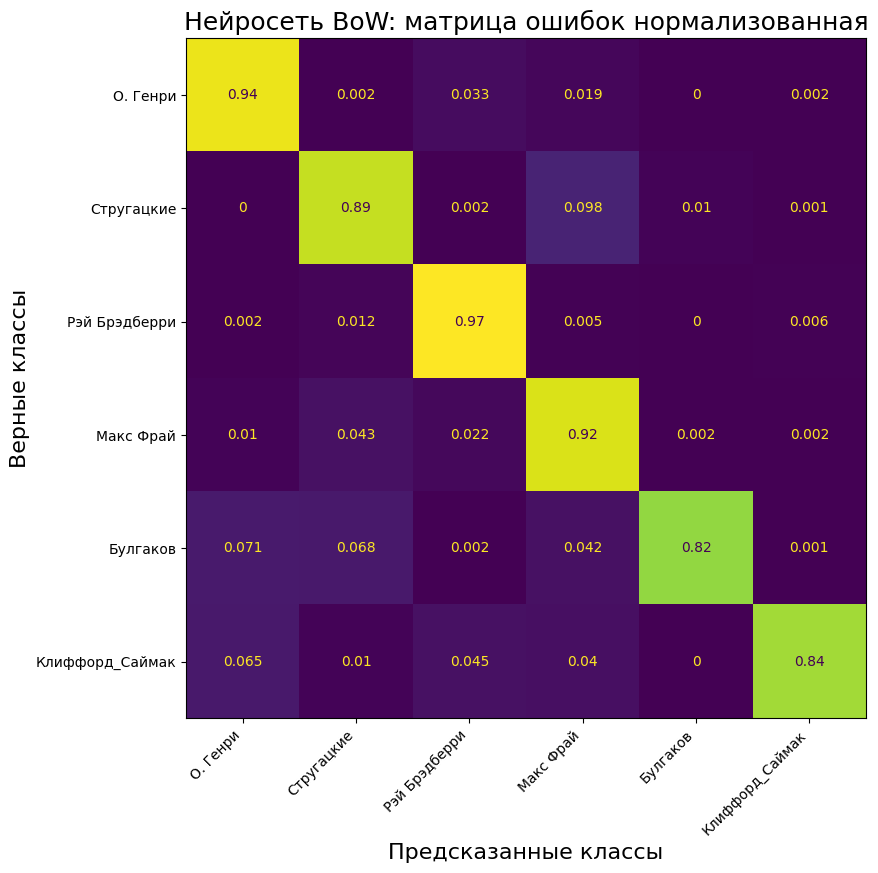

----------------------------------------------------------------------------------------------------
Нейросеть: BoW
Класс: О. Генри              94% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         98% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             92% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Булгаков              82% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       84% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  90%


In [31]:
# Создание последовательной модели нейросети
model_text_bow_softmax = Sequential()
# Первый полносвязный слой
model_text_bow_softmax.add(Dense(200, input_dim=VOCAB_SIZE, activation="relu"))
# Слой регуляризации Dropout
model_text_bow_softmax.add(Dropout(0.25))
# Слой пакетной нормализации
model_text_bow_softmax.add(BatchNormalization())
# Выходной полносвязный слой
model_text_bow_softmax.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_softmax,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         title='BoW')

**Выводы по итогам обучения модели BagOfWords**

По информации на эпохах и по графикам процесса обучения вы можете увидеть, что уже
со второй эпохи доля верных ответов и ошибка на обучающей выборке выходят на плато,
т.е. достигают предела в обучении и больше не меняются. На проверочной выборке
точность имеет тенденцию к легкому росту, а ошибка – к едва заметному снижению. В
целом получился хороший результат, и функция сообщает вам, что точность
распознавания текстов данной НС – 90%.

А как же прочесть график-матрицу, демонстрирующий точность сети? По вертикали даны
верные имена авторов, а по горизонтали – предсказанные имена. В сети с хорошей
точностью вы должны видеть яркую диагональ из верхнего левого угла в нижний правый,
в значениях которой будут дробные числа, близкие к единице. Это характеризует
точность предсказанных результатов. Именно такой исход вы и наблюдаете на графике-
матрице ошибок по данной модели!

Пример сохранения модели в файл для дальнейшего использования:

In [32]:
# Сохранение полной модели (архитектуры слоев и весов каждого слоя)
# Для чтения модели используется метод keras.models.load_model()
model_text_bow_softmax.save('model_text_bow_softmax.h5')

Наконец-то! Вы добрались до экспериментов со слоем Embedding. Как вы помните, этот
слой создает из каждого индекса слова отдельный вектор числовых значений, размер
которого равен параметру, указываемому при создании слоя в архитектуре.

Первая модель Embedding создаст для каждого слова в выборке вектор из 20 значений. Размер вектора, который создает слой, указывается в параметре **output_dim**.
Это довольно малый размер, сеть обучится быстро, но и точность может оказаться
невысокой. Параметр **input_dim** указывает количество уникальных значений (токенов), который данных слой будет способен обработать (если мы установим значение input_dim = N и подадим токен больше чем N, этот слой выдаст ошибку, по скольку у него не будут нужные веса для обработки этого токена).

Для работы с Embedding вы подадите выборки, созданные до преобразования
в Bag Of Words – просто **x_train** и **x_test**:

### Embedding + Dense: размерность эмбеддингов 20

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5402 - loss: 1.4442 - val_accuracy: 0.3433 - val_loss: 1.7936
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9983 - loss: 0.0189 - val_accuracy: 0.3768 - val_loss: 1.5656
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0089 - val_accuracy: 0.5182 - val_loss: 1.2532
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9992 - loss: 0.0060 - val_accuracy: 0.5728 - val_loss: 1.1306
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 0.6535 - val_loss: 0.9983
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.6683 - val_loss: 0.9722
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.6760 - val_loss: 0.9233
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0

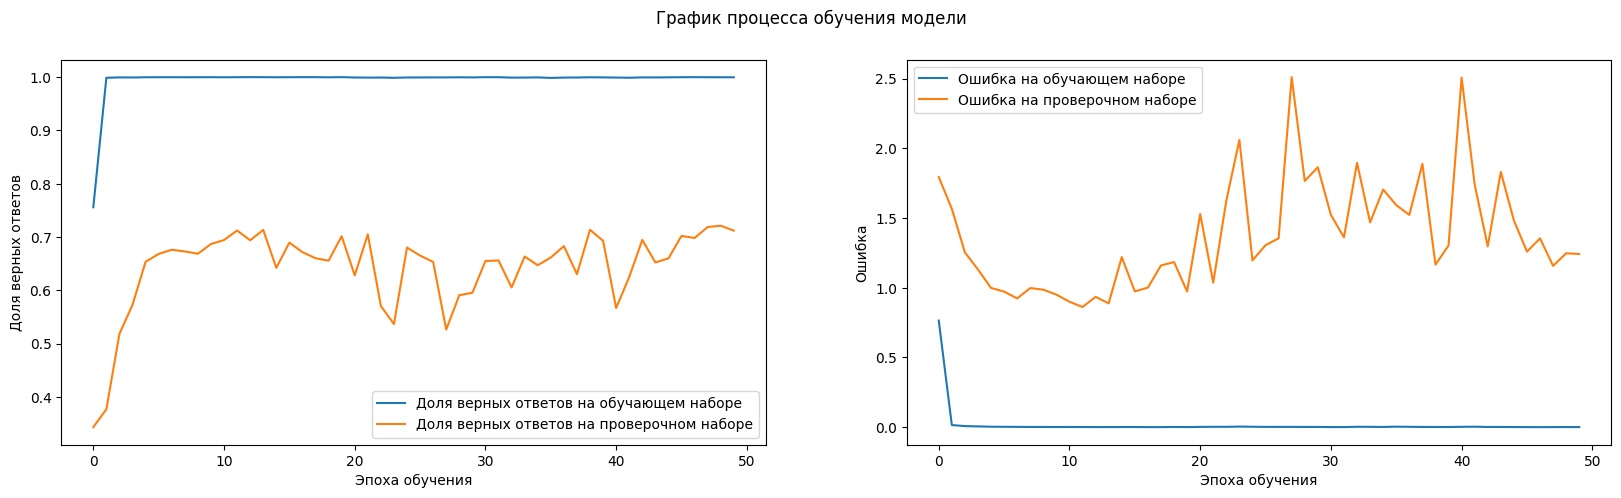

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


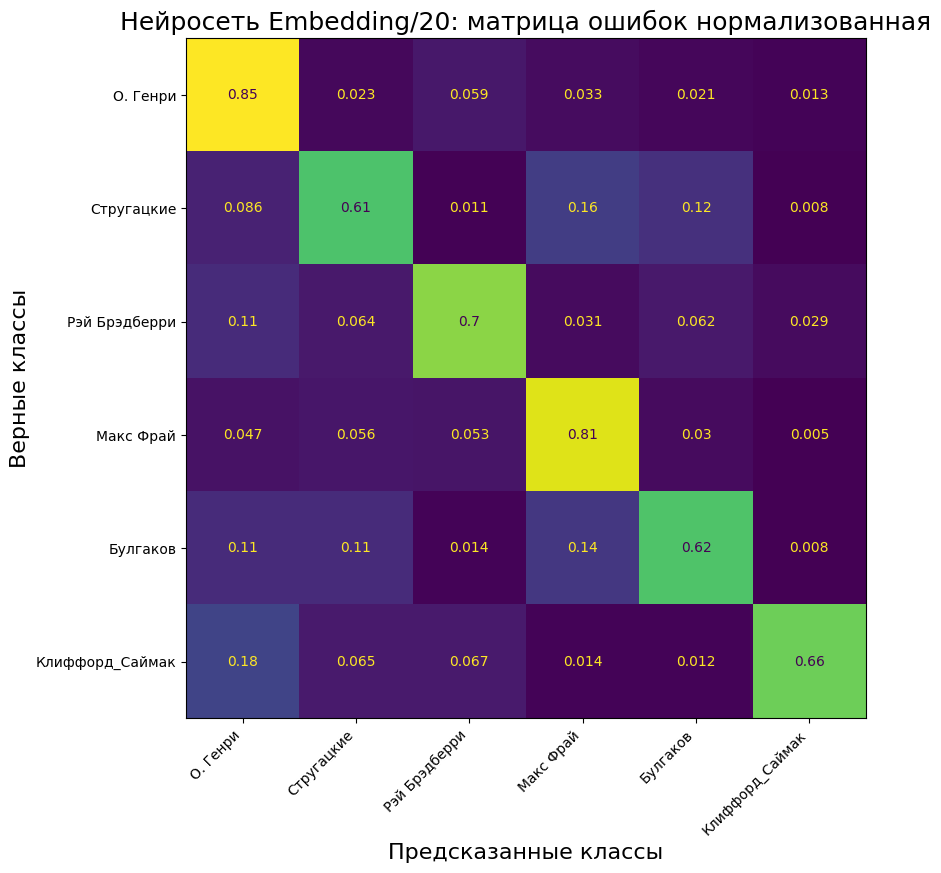

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/20
Класс: О. Генри              85% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Стругацкие            62% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         70% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             81% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Булгаков              62% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       66% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  71%


In [33]:
# Архитектура со слоем Embedding и регуляризацией
model_text_emb_20 = Sequential()
model_text_emb_20.add(Embedding(input_dim = VOCAB_SIZE, output_dim = 20, input_length=WIN_SIZE))
model_text_emb_20.add(SpatialDropout1D(0.2))
model_text_emb_20.add(Flatten())
model_text_emb_20.add(BatchNormalization())
model_text_emb_20.add(Dense(200, activation="relu"))
model_text_emb_20.add(Dropout(0.2))
model_text_emb_20.add(BatchNormalization())
model_text_emb_20.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде последовательностей индексов,
# а не векторов bag of words
compile_train_eval_model(model_text_emb_20,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         title='Embedding/20')

**Выводы по итогам обучения модели Embedding(20) + Dense**

Посмотрите на графики и данные по эпохам. Точность и ошибка на проверочном наборе
нарисовали пилу, хотя на обучающем по-прежнему полный штиль. Однако график
матрицы ошибок не даст вам себя обмануть: вы видите, как изменилась тональность на
диагонали и как упали значения точности. И правда, на последней эпохе сеть дала
точность распознавания 70%. Результат модели Embedding пока что сильно уступает Bag
Of Words.

Посмотрите, как изменится точность, если увеличить размер Embedding-пространства до
200, а также добавить новый слой одномерной регуляризации SpatialDropout1D.

### Embedding + Dense: размерность эмбеддингов **200**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6403 - loss: 1.3494 - val_accuracy: 0.3778 - val_loss: 1.8015
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.4284 - val_loss: 1.3980
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.5643 - val_loss: 1.1913
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.6596 - val_loss: 1.0025
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.7009 - val_loss: 0.9282
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 1.0000 - loss: 7.8212e-04 - val_accuracy: 0.7170 - val_loss: 0.9071
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 1.0000 - loss: 6.0071e-04 - val_accuracy: 0.7160 - val_loss: 0.9088
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 4.9388e

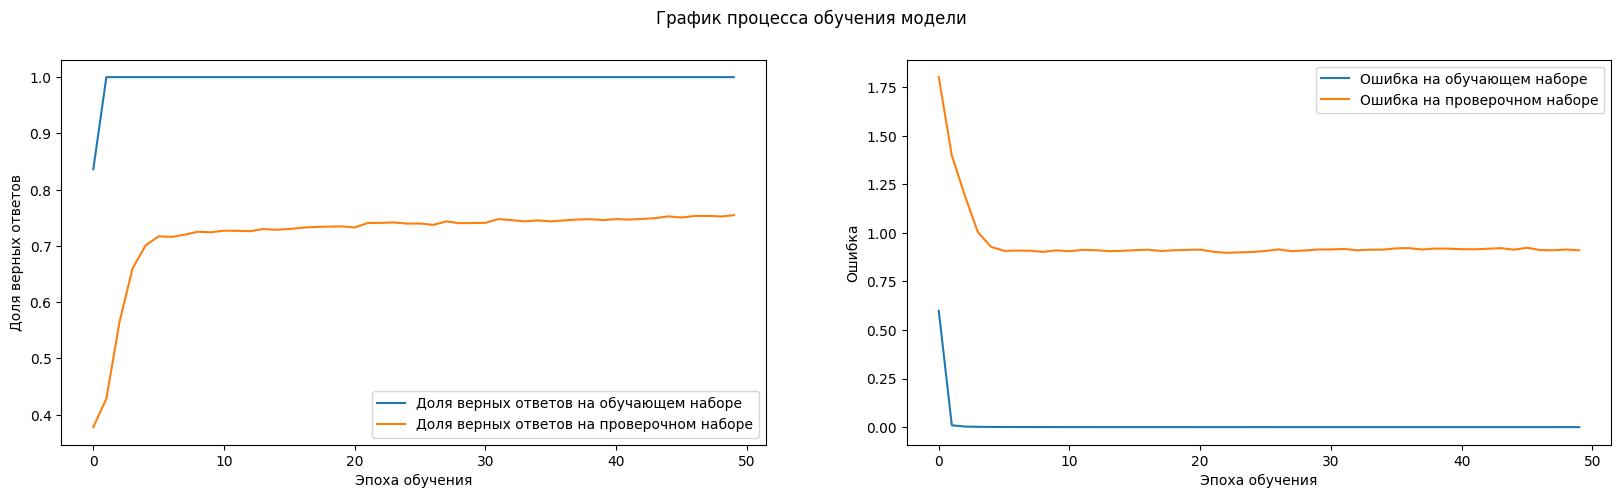

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


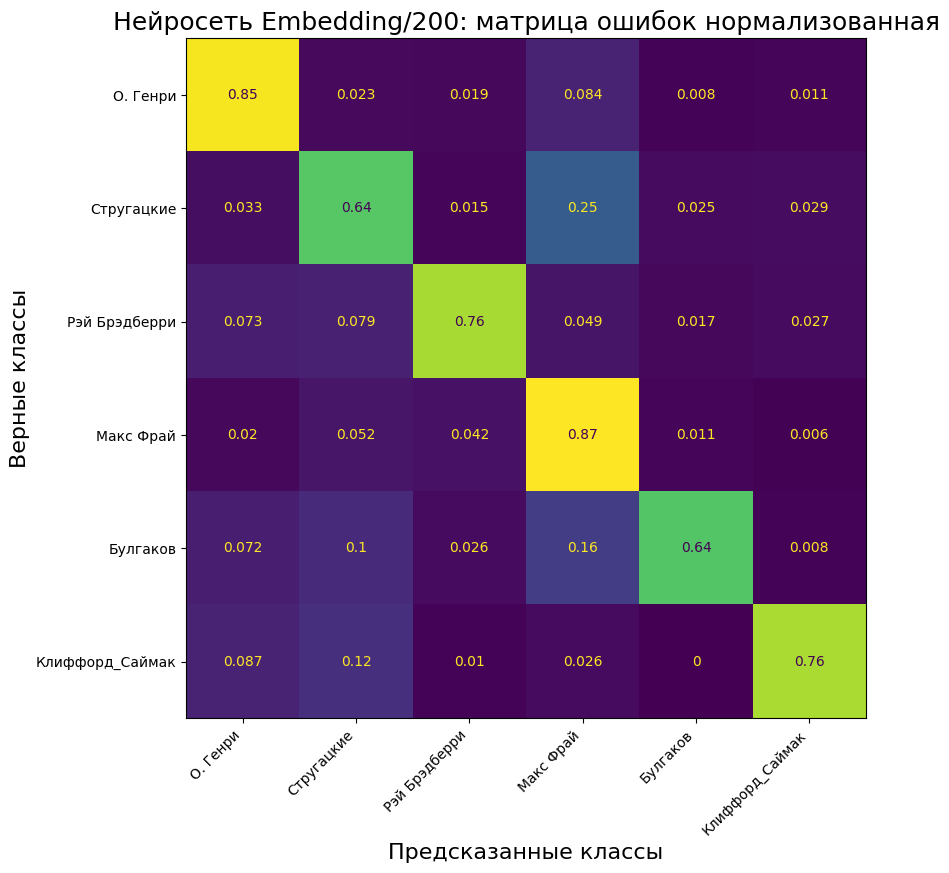

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/200
Класс: О. Генри              86% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Стругацкие            64% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         76% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             87% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Булгаков              64% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       76% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  75%


In [34]:
#Создаём сеть с Embedding слоем
model_text_emb_200 = Sequential()
model_text_emb_200.add(Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE))
model_text_emb_200.add(SpatialDropout1D(0.2))
model_text_emb_200.add(Flatten())
model_text_emb_200.add(BatchNormalization())
model_text_emb_200.add(Dense(200, activation="relu"))
model_text_emb_200.add(Dropout(0.2))
model_text_emb_200.add(BatchNormalization())
model_text_emb_200.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_200,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         title='Embedding/200')

**Вывод по данной модели** – везде плато на графиках, что нехорошо, и скорее всего модель
столкнулась с переобучением. По сравнению с предыдущей моделью точность
распознавания выросла на 5%, но это все равно гораздо меньше, чем точности при
подходе с Bag Of Words. Похоже, что «мешок слов» – оптимальный способ решения
задачи по классификации текстов?

Дайте Embedding-модели еще один шанс, убрав при этом слои регуляризации из
архитектуры.

### Embedding + Dense: размерность эмбеддингов **200** без слоев регуляризации **SpatialDropout1D, Droupout**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6802 - loss: 1.3513 - val_accuracy: 0.1538 - val_loss: 1.7391
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9999 - loss: 0.0093 - val_accuracy: 0.4336 - val_loss: 1.4964
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.5305 - val_loss: 1.2626
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6235 - val_loss: 1.0326
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 8.1212e-04 - val_accuracy: 0.6730 - val_loss: 0.9463
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 5.5948e-04 - val_accuracy: 0.6871 - val_loss: 0.9389
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 1.0000 - loss: 3.9314e-04 - val_accuracy: 0.6901 - val_loss: 0.9472
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 3.03

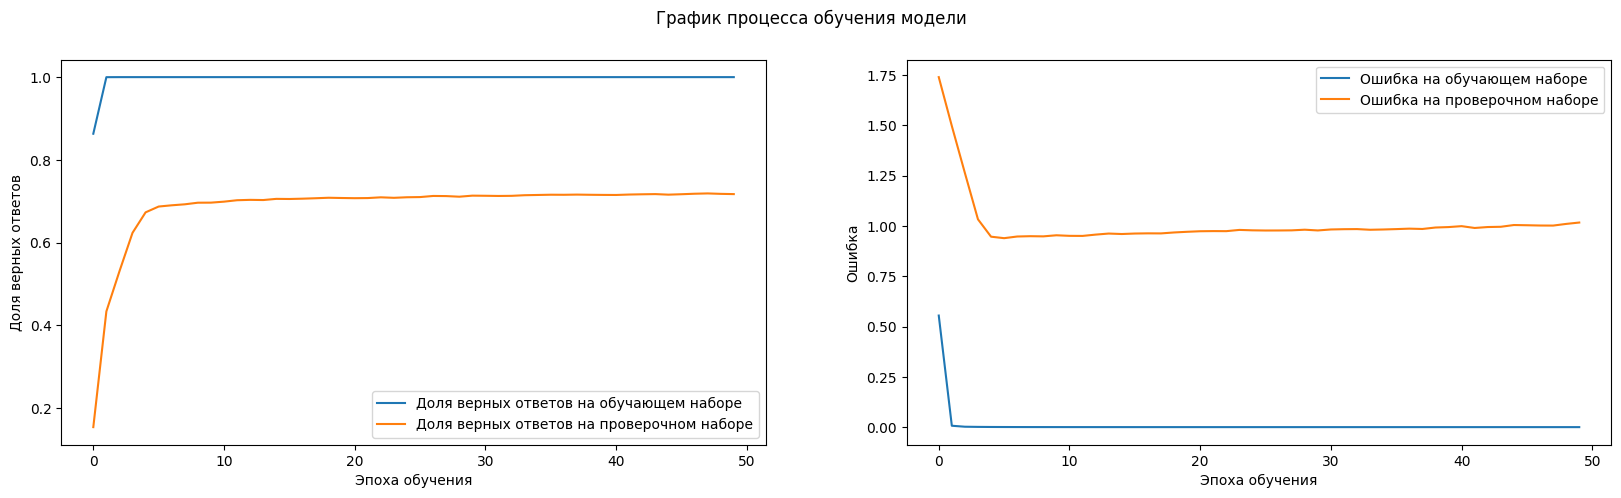

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


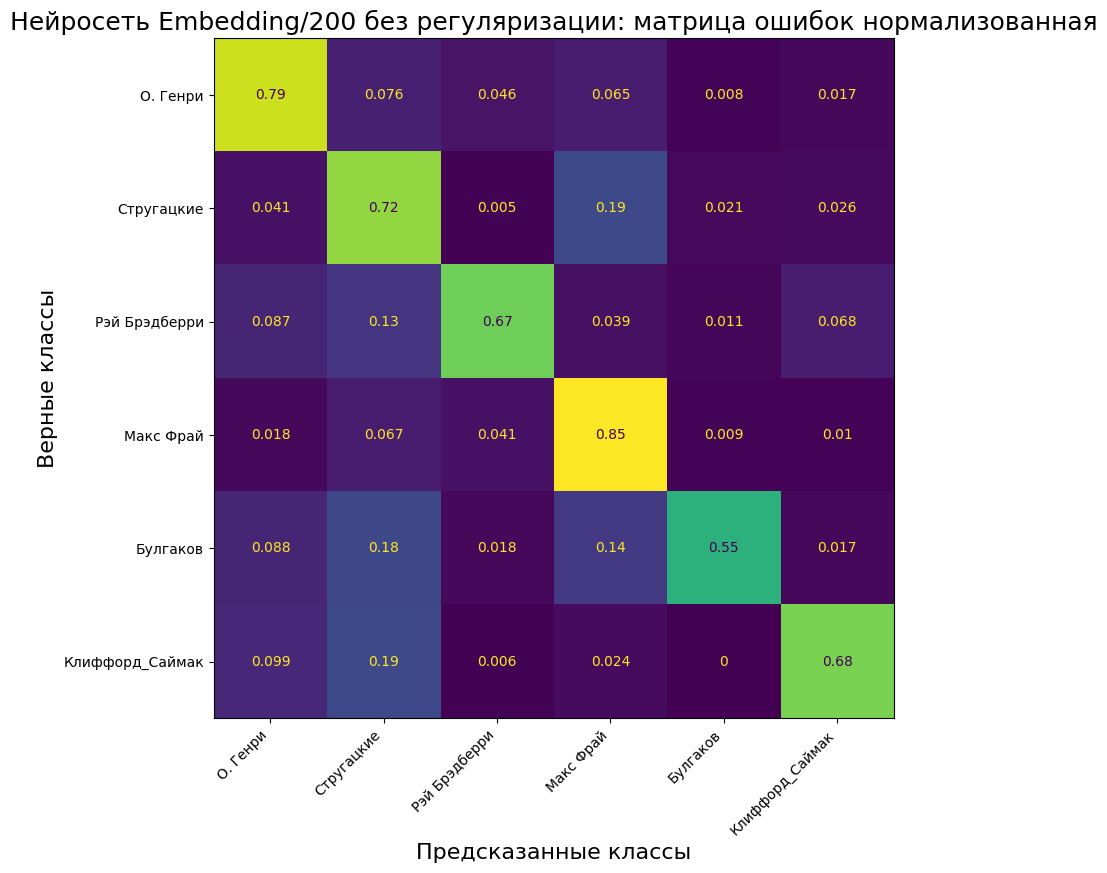

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/200 без регуляризации
Класс: О. Генри              79% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Стругацкие            72% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         67% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             85% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Булгаков              55% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Клиффорд_Саймак       68% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  71%


In [35]:
#Создаём сеть с Embedding слоем
model_text_emb_200_nr = Sequential()
model_text_emb_200_nr.add(Embedding(VOCAB_SIZE, 200, input_length=WIN_SIZE))
model_text_emb_200_nr.add(Flatten())
model_text_emb_200_nr.add(BatchNormalization())
model_text_emb_200_nr.add(Dense(200, activation="relu"))
model_text_emb_200_nr.add(BatchNormalization())
model_text_emb_200_nr.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_200_nr,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         epochs=50,
                         title='Embedding/200 без регуляризации')

Увы! Точность последней модели совпала с точностью первой Embedding-сети, хотя
параметр размера пространства здесь численно выше в 10 раз. Пусть 73% не самый
плохой результат, но и графики обучения, и статистика по эпохам значительно уступают
Bag Of Words-модели. Хорошо, что AI-разработчики придумали несколько подходов для
задач по обработке текстов! То, что один подход сейчас лучше работает не означает, что
он будет работать так же для любой задачи. Поэтому не забывайте экспериментировать, и
тогда каждый подход найдет свою область применения!

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1vpNRvLYFs9NddIiuMl3-HIpUBeOj8Up5?usp=sharing)

2. Практический ноутбук 1

3. [Практический ноутбук 2](https://colab.research.google.com/drive/1879mpTpzhYyKwa79sPPG4u4TUBMLjhGg?usp=sharing)
